# COVID-19 és Dohányzás Kapcsolatának Elemzése - Ágens Projekt

## Projektcsapat:
- Svec Antal (EZJRP1) - Adatfeldolgozás, ágens fejlesztés
- Angi Dávid (SW0CBI) - Adat validáció, frontend
- Pereszlényi Kornélia (DPZH7H) - Adatgyűjtés, adatelemzés, dokumentálás

Ez a projekt a COVID-19 és a dohányzás közötti kapcsolatot vizsgálja cord19 adatbázisban található tudományos publikációk elemzésével.
Az ágens képes a releváns információk kinyerésére, validálására és elemzésére, valamint
felhasználóbarát módon történő megjelenítésére.

## 1. Szükséges csomagok telepítése

A szükséges csomagok telepítése pip segítségével
Ezek a csomagok biztosítják az adatfeldolgozás, gépi tanulás és vizualizáció eszközeit

Az angol nyelvi modell telepítése a spaCy könyvtárhoz
Ez a modell szükséges a szövegfeldolgozáshoz és elemzéshez

In [ ]:
!pip install llama-index llama-index-embeddings-huggingface llama-index-llms-huggingface bitsandbytes torch spacy hdbscan umap-learn scikit-learn
!python -m spacy download en_core_web_lg

## 2. Importálások és beállítások

In [32]:
import os
import pandas as pd
import numpy as np
import json
import re, string
import unicodedata
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import torch
import csv
from sklearn.cluster import KMeans

from llama_index.core import Settings, Document, StorageContext, VectorStoreIndex, load_index_from_storage
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core.memory import ChatMemoryBuffer
from llama_index.core.postprocessor import MetadataReplacementPostProcessor

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from nltk.stem import PorterStemmer
from collections import Counter

from sentence_transformers import SentenceTransformer     # or use TF-IDF if you prefer
# Dimensionality reduction & clustering
import umap.umap_ as umap
import seaborn as sns
import hdbscan

In [33]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
base_path = "/home/anton/jupyter-env/nlp-project"
os.chdir(base_path)

# print pwd
print("Current working directory:", os.getcwd())

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tqdm.pandas()

model_name_embed = "sentence-transformers/all-MiniLM-L6-v2"
model_name_llm = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
chunk_size = 200
persist_dir = "storage2"

# Switch: Use vector DB or not
USE_VECTOR_DB = True  # Set to False to run agent without vector DB

Device: cuda:0
Current working directory: /home/anton/jupyter-env/nlp-project


[nltk_data] Downloading package punkt to /home/anton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anton/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Metaadatok betöltése CSV fájlból
A metaadatok a cord19 adatbázisból történik, amit már előzetesen leszűrtünk. A szűrés a Null értékek eltávolítására és a releváns mezők kiválasztására vonatkozik.

Definiáltuk a dohányzás és COVID-19 kulcsszavakat, amelyek alapján a releváns publikációkat azonosítjuk.

In [34]:
metadata_path = "articles_with_similarity_and_categories.csv"
metadata = pd.read_csv(metadata_path, dtype=str)

smoking_keywords = [
    "smoking", "smoker", "smoke", "ecigarett", "cigarett", "tobacco", "cigarette", "nicotine",
    "vaping", "vape", "e-cigarette", "cigar", "weed", "marijuana"
]
covid_terms = ["covid", "sars-cov-2", "coronavirus"]

## A leszűrt cikkek publikálási dátum elemzése.
Érdekesség, hogy olyan cikk is szerepel az adatbázisban, amely 1952-ben jelent meg, de a legtöbb cikk 2020-ban és 2021-ben publikált.
A kutatások nagyobb számban már 2005-óta kezdtek megjelenni.

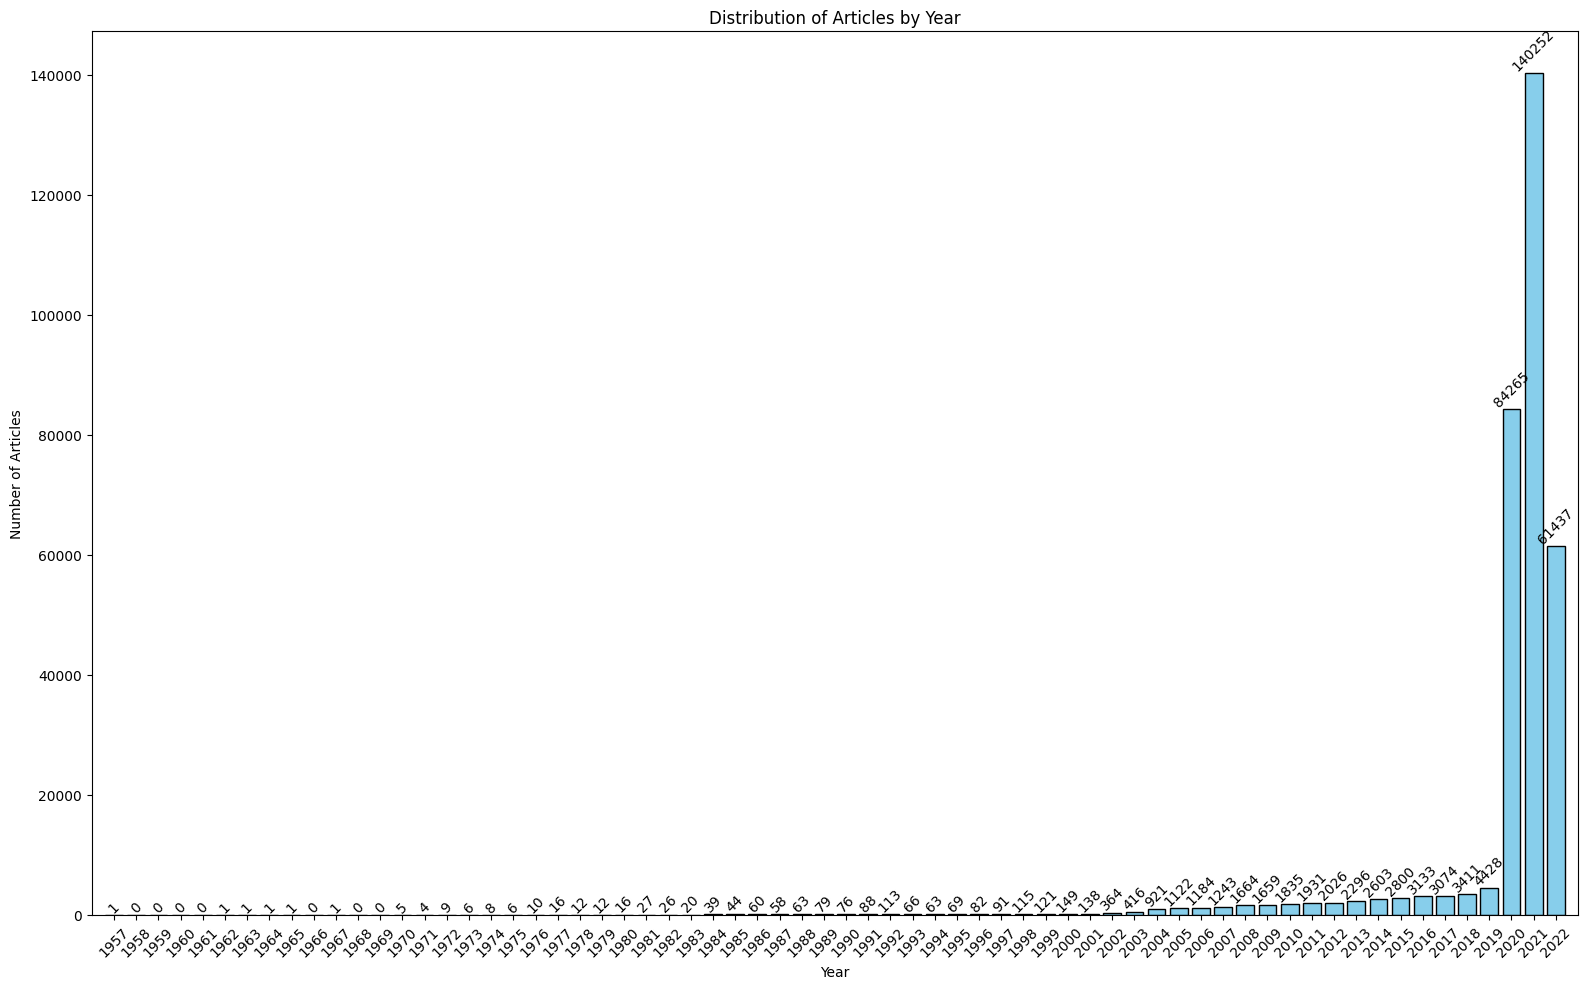

In [35]:
metadata['publish_time'] = pd.to_datetime(metadata['publish_time'], errors='coerce')
metadata['year'] = metadata['publish_time'].dt.year

# Count articles per year and sort
year_counts = metadata['year'].value_counts().sort_index()

# Fix for float issue in range
min_year = int(year_counts.index.min())
max_year = int(year_counts.index.max())

# Ensure all years are included
all_years = pd.Series(0, index=range(min_year, max_year + 1))
year_counts = all_years.add(year_counts, fill_value=0).astype(int)

# Plot
plt.figure(figsize=(16, 10))
bars = plt.bar(year_counts.index, year_counts.values, color='skyblue', edgecolor='black')

# Add text labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}', ha='center', va='bottom', fontsize=10, rotation=45)

plt.xticks(year_counts.index, rotation=45)
plt.xlim(min_year - 1, max_year + 1)
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles by Year')
plt.tight_layout()
plt.show()

## Releváns publikációk azonosítása

A `metadata` adathalmazban szűrés elvégzés során szemantikai hasonlóságot mértünk a title és abstract szövegekből minden sorhoz. Illetve egy másik módszerrel, ami csak kulcsszavak jelenlétét vizsgálja a title és abstract mezőkben. A két módszer eredményeit összevetettük, és a közös találatokat tartottuk meg.

In [6]:
metadata['smoking_similarity'].astype(float).describe()

count    326400.000000
mean          0.046898
std           0.062099
min          -0.238083
25%           0.006767
50%           0.046804
75%           0.085664
max           0.621439
Name: smoking_similarity, dtype: float64

In [7]:
smoking_papers_by_match = metadata[
    metadata["title"].str.lower().str.contains('|'.join(smoking_keywords), na=False) |
    metadata["abstract"].str.lower().str.contains('|'.join(smoking_keywords), na=False)
].copy()
smoking_papers_by_score = metadata[
    metadata["smoking_similarity"].astype(float) > 0.15
].copy()

In [8]:
# how many same matching papers do we have?
print(f"Smoking papers by match: {len(smoking_papers_by_match)}")
print(f"Smoking papers by score: {len(smoking_papers_by_score)}")
#how many same papers do we have?
print(f"Same papers: {len(set(smoking_papers_by_match['cord_uid']).intersection(set(smoking_papers_by_score['cord_uid'])))}")

#select intersection
filtered_papers = smoking_papers_by_match[
    smoking_papers_by_match["cord_uid"].isin(smoking_papers_by_score["cord_uid"])
].copy()

filtered_papers.info()

Smoking papers by match: 4372
Smoking papers by score: 13699
Same papers: 2175
<class 'pandas.core.frame.DataFrame'>
Index: 2175 entries, 40 to 326286
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cord_uid            2175 non-null   object        
 1   title               2175 non-null   object        
 2   abstract            2175 non-null   object        
 3   publish_time        2163 non-null   datetime64[ns]
 4   authors             2174 non-null   object        
 5   pdf_json_files      2175 non-null   object        
 6   smoking_similarity  2175 non-null   object        
 7   covid_similarity    2175 non-null   object        
 8   category            2175 non-null   object        
 9   year                2163 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 186.9+ KB


## Cikkek teljes szövegeinek betöltése

In [ ]:
def extract_body_text(json_path):
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return ' '.join(para['text'] for para in data.get('body_text', []))
    except Exception:
        return None

def get_full_text(row):
    if pd.notna(row['pdf_json_files']):
        for json_path in row['pdf_json_files'].split('; '):
            full_path = os.path.join(base_path, json_path.strip())
            if os.path.exists(full_path):
                return extract_body_text(full_path)
    return None

tqdm.pandas(desc="Extracting full text sections")
filtered_papers['full_text'] = filtered_papers.progress_apply(get_full_text, axis=1)

filtered_papers = filtered_papers.dropna(subset=['title', 'abstract', 'full_text'])

filtered_papers['combined_text'] = (
    filtered_papers['title'].fillna('') + '. ' +
    filtered_papers['abstract'].fillna('') + '. ' +
    filtered_papers['full_text'].fillna('')
)
filtered_papers.info()


Extracting full text sections: 100%|██████████████████████████████████████████████| 2175/2175 [00:02<00:00, 1020.55it/s]


<class 'pandas.core.frame.DataFrame'>
Index: 2175 entries, 40 to 326286
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cord_uid            2175 non-null   object        
 1   title               2175 non-null   object        
 2   abstract            2175 non-null   object        
 3   publish_time        2163 non-null   datetime64[ns]
 4   authors             2174 non-null   object        
 5   pdf_json_files      2175 non-null   object        
 6   smoking_similarity  2175 non-null   object        
 7   covid_similarity    2175 non-null   object        
 8   category            2175 non-null   object        
 9   year                2163 non-null   float64       
 10  full_text           2175 non-null   object        
 11  combined_text       2175 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 220.9+ KB


## Külön keresett 87 cikk hozzátöltése az adatbázishoz
Covid és dohányzás témában, amelyek nem szerepeltek a cord19 adatbázisban, de relevánsak lehetnek. Ezeket a cikkeket manuálisan gyűjtöttük össze és töltöttük fel.
Ez a szakasz egy `clean_text` függvényt definiál és alkalmaz, amely elvégzi a szükséges tisztítási lépéseket:
- Unicode normalizálás (karakterek egységesítése).
- Kódolási hibák kezelése.
- HTML/XML címkék eltávolítása.
- LaTeX matematikai formulák eltávolítása.
- Numerikus hivatkozások (pl. [1], (2)) eltávolítása.
- Nem nyomtatható vagy nem ASCII karakterek eltávolítása.
- Többszörös szóközök egységesítése.
- Kisbetűssé alakítás.
- Írásjelek eltávolítása.
A tisztítás célja, hogy egységes, "tiszta" szöveget kapjunk, amely alkalmasabb a tokenizálásra, beágyazásra és egyéb NLP feladatokra, javítva ezzel az elemzés pontosságát és megbízhatóságát.

In [ ]:
external_papers_path = "extracted_texts.json"
if os.path.exists(external_papers_path):
    with open(external_papers_path, 'r') as f:
        external_papers = json.load(f)
else:
    external_papers = {}


new_rows = []
for name, text in external_papers.items():
    new_rows.append({
        'cord_uid': name,
        'title': name,
        'combined_text': text
    })

# Convert to DataFrame with the same columns as filtered_papers
new_df = pd.DataFrame(new_rows)


# Add any missing columns from filtered_papers with None values
for col in filtered_papers.columns:
    if col not in new_df.columns:
        new_df[col] = None

# Concatenate the DataFrames
extended_papers = pd.concat([filtered_papers, new_df], ignore_index=True)

/tmp/ipykernel_1298/3846149692.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extended_papers = pd.concat([filtered_papers, new_df], ignore_index=True)


In [11]:
# drop null values in 'combined_text' column
extended_papers = extended_papers.dropna(subset=['combined_text'])
extended_papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2262 entries, 0 to 2261
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cord_uid            2262 non-null   object        
 1   title               2262 non-null   object        
 2   abstract            2175 non-null   object        
 3   publish_time        2163 non-null   datetime64[ns]
 4   authors             2174 non-null   object        
 5   pdf_json_files      2175 non-null   object        
 6   smoking_similarity  2175 non-null   object        
 7   covid_similarity    2175 non-null   object        
 8   category            2175 non-null   object        
 9   year                2163 non-null   float64       
 10  full_text           2175 non-null   object        
 11  combined_text       2262 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(10)
memory usage: 212.2+ KB


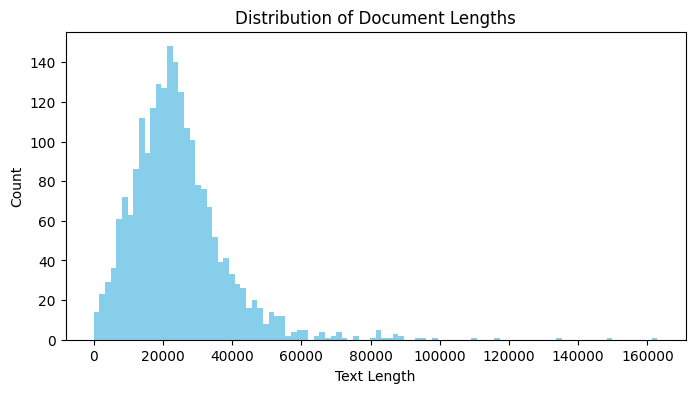

In [12]:
punct_table = str.maketrans("", "", string.punctuation)
def clean_text(text):
    text = unicodedata.normalize("NFKC", text)
    text = text.encode("utf-8", "ignore").decode("utf-8", "ignore")
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"\$.*?\$", " ", text)
    text = re.sub(r"\[\d+\]|\(\d+\)", " ", text)
    text = re.sub(r"[^\x20-\x7E]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = text.lower().strip()
    text = text.translate(punct_table)
    return text

extended_papers['combined_text'] = extended_papers['combined_text'].apply(clean_text)

# --- Outlier Detection (Text Length) ---
plt.figure(figsize=(8, 4))
plt.hist(extended_papers['full_text'].str.len(), bins=100, color='skyblue')
plt.title("Distribution of Document Lengths")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

## Adathalmaz elemzés, megértése és előkészítése
Az adathalmazban lévő dokumentumok hossza jelentősen eltérhet. Fontos megvizsgálni ezt az eloszlást, mert a kiugróan rövid vagy hosszú dokumentumok problémákat okozhatnak:
- Túl rövid dokumentumok: Lehet, hogy nem tartalmaznak elegendő információt, vagy adatkinyerési hibára utalnak.
- Túl hosszú dokumentumok: Megnehezíthetik a modellek (pl. LLM-ek korlátozott kontextusablaka miatt) feldolgozását, vagy aránytalanul nagy súlyt kaphatnak bizonyos elemzésekben.
Ebben a szakaszban vizualizáljuk a (teljes) szöveghosszak eloszlását egy hisztogram segítségével. Meghatározzuk az egyedi karakterek számát is a tisztított szövegekben,
ami további betekintést nyújt az adatok jellegébe. Létrehozunk új oszlopokat a karakter- és szószám tárolására, majd kiírjuk ezek leíró statisztikáit (átlag, szórás, minimum, maximum, kvartilisek).
Ez segít azonosítani a potenciális kiugró értékeket és megalapozza a következő lépésben történő szűrést.

In [13]:
# How many uniques characters in the combined_text?
unique_chars = set(''.join(extended_papers['combined_text'].dropna()))
sorted_unique_chars = sorted(unique_chars)
print(f"Number of unique characters in combined_text: {len(sorted_unique_chars)}")
print("Unique characters in combined_text:", sorted_unique_chars)

Number of unique characters in combined_text: 37
Unique characters in combined_text: [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [14]:
# count in each row character and wors, create new columns
extended_papers['text_length'] = extended_papers['combined_text'].str.len()
extended_papers['word_count'] = extended_papers['combined_text'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
# print statustics of the text_length and word_count columns
print("Text Length Statistics:")
print(extended_papers['text_length'].describe())
print("Word Count Statistics:")
print(extended_papers['word_count'].describe())

Text Length Statistics:
count      2262.000000
mean      22863.445623
std       13569.830804
min        1106.000000
25%       14003.000000
50%       21361.500000
75%       28772.000000
max      239830.000000
Name: text_length, dtype: float64
Word Count Statistics:
count     2262.000000
mean      3561.654288
std       2115.882445
min        169.000000
25%       2181.500000
50%       3325.500000
75%       4477.750000
max      37862.000000
Name: word_count, dtype: float64


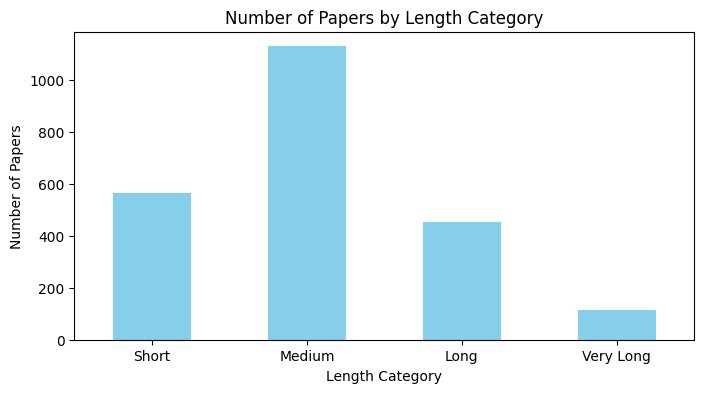

In [15]:
# Create a diagram of the text length and word count grouped by statistics under 25%, between 25% and 75%, above 75%, and very long above 95%
q25 = extended_papers['text_length'].quantile(0.25)
q75 = extended_papers['text_length'].quantile(0.75)
q95 = extended_papers['text_length'].quantile(0.95)

def categorize_length(row):
    if row['text_length'] > q95:
        return 'Very Long'
    elif row['text_length'] > q75:
        return 'Long'
    elif row['text_length'] < q25:
        return 'Short'
    else:
        return 'Medium'

extended_papers['length_category'] = extended_papers.apply(categorize_length, axis=1)
# Count the number of papers in each category
length_counts = extended_papers['length_category'].value_counts().reindex(['Short', 'Medium', 'Long', 'Very Long'])
# Plot the counts
plt.figure(figsize=(8, 4))
length_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Papers by Length Category")
plt.xlabel("Length Category")
plt.ylabel("Number of Papers")
plt.xticks(rotation=0)
plt.show()

## Adathalmaz szűkítés
Az előző lépésben feltártuk a szöveghosszak eloszlását. Most ezt az információt használjuk fel az adatok további finomítására.
Először kategorizáljuk a dokumentumokat a hosszuk alapján ('Rövid', 'Közepes', 'Hosszú', 'Nagyon hosszú') a kvartilisek (25%, 75%, 95%) segítségével.
Ez segít jobban megérteni az adathalmaz összetételét, amit egy oszlopdiagramon vizualizálunk is.
A fő cél azonban a kiugró értékek eltávolítása. Egy alsó és egy felső küszöbértéket (pl. 1000 és 55000 karakter) alkalmazva kiszűrjük azokat a dokumentumokat,
amelyek valószínűleg túl rövidek ahhoz, hogy hasznos információt tartalmazzanak, vagy túl hosszúak a hatékony feldolgozáshoz.
Ez a szűrés javítja az adathalmaz minőségét és konzisztenciáját, ami pozitívan hat a későbbi modellezési és elemzési lépésekre.

In [ ]:
extended_papers = extended_papers[
    (extended_papers['text_length'] > 1000) & (extended_papers['text_length'] < 55000)
]
extended_papers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2219 entries, 0 to 2261
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   cord_uid            2219 non-null   object        
 1   title               2219 non-null   object        
 2   abstract            2137 non-null   object        
 3   publish_time        2125 non-null   datetime64[ns]
 4   authors             2136 non-null   object        
 5   pdf_json_files      2137 non-null   object        
 6   smoking_similarity  2137 non-null   object        
 7   covid_similarity    2137 non-null   object        
 8   category            2137 non-null   object        
 9   year                2125 non-null   float64       
 10  full_text           2137 non-null   object        
 11  combined_text       2219 non-null   object        
 12  text_length         2219 non-null   int64         
 13  word_count          2219 non-null   int64         
 1

In [ ]:
df = filtered_papers.copy()
df.rename(columns={'full_text': 'article_text', 'combined_text': 'full_text'}, inplace=True)

# --- Completeness & Consistency ---
print("Checking for missing values:")
print(df.isnull().sum())

Checking for missing values:
cord_uid               0
title                  0
abstract               0
publish_time          12
authors                1
pdf_json_files         0
smoking_similarity     0
covid_similarity       0
category               0
year                  12
article_text           0
full_text              0
dtype: int64


## Témamodellezés (LDA)

A Latent Dirichlet Allocation (LDA) egy népszerű, felügyeletlen gépi tanulási módszer, amely alkalmas nagy szövegkorpuszokban rejlő látens témák feltárására.
Ebben a szakaszban LDA-t alkalmazunk a validációs DataFrame (`df`) `full_text` oszlopára, hogy:
1. Feltárjuk a fő témaköröket, amelyekről a dohányzással és COVID-19-cel (elvileg) kapcsolatos cikkek szólnak.
2. Validáljuk a korábbi szűrési lépések hatékonyságát: azonosított témák valóban relevánsak-e?
3. Betekintést nyerjünk a korpusz tartalmi összetételébe.
A folyamat lépései:
- Szövegek vektorizálása TF-IDF (Term Frequency-Inverse Document Frequency) módszerrel, amely súlyozza a szavakat a dokumentumon belüli és a korpuszon belüli gyakoriságuk alapján.
- Az LDA modell inicializálása (megadott számú témával, pl. 5) és illesztése a TF-IDF mátrixra.
- Az egyes témákhoz tartozó legjellemzőbb szavak kiíratása.

### A harmadik kulcsszó: Alkohol
A dohányzás és a COVID-19 kapcsolatának vizsgálata során az alkohol is kapcsolódik a témához.

In [18]:
# --- Topic Modeling (LDA) ---
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['full_text'].fillna(''))
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx+1}:")
    print([terms[i] for i in topic.argsort()[-10:][::-1]])

Topic #1:
['covid', '19', 'patients', 'preprint', 'smoking', 'risk', 'smokers', 'license', 'medrxiv', 'mortality']
Topic #2:
['smoking', 'use', 'tobacco', 'health', 'participants', 'study', 'covid', '19', 'alcohol', 'pandemic']
Topic #3:
['cannabis', 'icu', 'tissues', 'serum', 'cellular', 'mice', 'tissue', 'receptor', 'nasal', 'el']
Topic #4:
['patients', 'copd', 'asthma', 'lung', 'patient', 'respiratory', 'covid', '19', 'evali', 'pneumonia']
Topic #5:
['cells', 'expression', 'ace2', 'et', 'al', 'lung', 'cell', 'smoke', 'protein', 'cov']



A Word2Vec egy népszerű technika szóbeágyazások (word embeddings) tanulására. Ezek a beágyazások sűrű vektorreprezentációk, amelyek képesek megragadni a szavak közötti szemantikai kapcsolatokat.
Ahhoz, hogy a Word2Vec modellt tanítani tudjuk, először elő kell készíteni a szöveges adatokat:
1. **Tokenizálás:** A szövegeket szavakra (tokenekre) bontjuk.
2. **Kisbetűsítés és Stop Szó Eltávolítás:** Egységesítjük a szavakat és eltávolítjuk a gyakori, de kevés jelentést hordozó szavakat (pl. 'a', 'the', 'is').
3. **Szótövezés (Stemming):** A szavakat a gyökerükre redukáljuk (pl. 'smoking', 'smokes' -> 'smoke'). Ez segít csökkenteni a szókincs méretét és csoportosítani a rokon értelmű szavakat.
4. **Szókincs Építés:** Létrehozunk egy szótárat (`vocab`), amely a leggyakoribb (pl. top 1000) szótöveket tartalmazza, és mindegyikhez egy egyedi indexet rendel. Azokat a szavakat, amelyek nem szerepelnek a top N-ben, egy speciális '<UNK>' (ismeretlen) tokenhez rendeljük.
Ez a folyamat átalakítja a nyers szöveget egy strukturáltabb formátumba, amely alkalmas a Word2Vec modell bemeneteként.

A Word2Vec modell tanítás végeztével kinyerjük a tanult beágyazási mátrixot (`word_embeddings`) a modellből.
Ezeket a vektorokat és a hozzájuk tartozó szavakat (metaadat) TSV (Tab Separated Values) fájlokba mentjük, ami lehetővé teszi a beágyazások vizualizálását külső eszközökkel (pl. TensorBoard Embedding Projector).

In [19]:


stemmer = PorterStemmer()

def tokenize(text):
    tokens = text.lower().split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return tokens

counter = Counter()
for example in tqdm(filtered_papers["full_text"].values):
    counter.update(tokenize(example))

vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(1000), 1)}
vocab["<UNK>"] = 0

def context_target_pairs(text, window_size=2):
    tokens = [vocab.get(token, 0) for token in tokenize(text)]
    pairs = []
    for i in range(window_size, len(tokens) - window_size):
        context = tokens[i - window_size:i] + tokens[i + 1:i + 1 + window_size]
        target = tokens[i]
        pairs.append((context, target))
    return pairs

pairs = []
for text in tqdm(filtered_papers["full_text"].values):  # Csak egy részhalmazt veszünk a gyors tanítás érdekében
    pairs.extend(context_target_pairs(text))

print(f"Total context-target pairs: {len(pairs)}")

total_pairs = pairs.copy()
pairs = []
for item in tqdm(total_pairs):
  if item[1] != 0:
    pairs.append(item)
  else:
    continue
print(f"Total context-target pairs after filtering: {len(pairs)}")

100%|███████████████████████████████████████████████████████████████████████████████| 2175/2175 [00:42<00:00, 51.35it/s]


Total context-target pairs: 5308543


100%|███████████████████████████████████████████████████████████████████| 5308543/5308543 [00:00<00:00, 10030947.11it/s]

Total context-target pairs after filtering: 3059603


In [20]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

torch.manual_seed(42)

class Word2VecDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        context, target = self.pairs[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)

train_dataset = Word2VecDataset(pairs)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

items, labels = next(iter(train_loader))
len(items), len(labels), items[0], labels[0]

(256, 256, tensor([398,  89, 893,   0]), tensor(440))

In [25]:
import torch.nn as nn

# CBOW
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.linear = nn.Linear(embed_size, vocab_size)

    def forward(self, context):
        embeds = self.embeddings(context).mean(dim=1)
        out = self.linear(embeds)
        return out

embed_size = 100
model = Word2Vec(len(vocab), embed_size).to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
for epoch in range(epochs):
    total_loss = []
    # Create a new progress bar for each epoch
    pbar = tqdm(train_loader)
    for context, target in pbar:
        context = context.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        output = model(context)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
        avg_loss = sum(total_loss) / len(total_loss)
        pbar.set_description(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 5, Loss: 5.0824: 100%|█████████████████████████████████████████████████████| 11952/11952 [01:06<00:00, 179.73it/s]


In [26]:
word_embeddings = model.embeddings.weight.cpu().detach().numpy()
print("Beágyazás mátrix mérete:", word_embeddings.shape)

with open("vectors.tsv", "w", newline='') as v_f, open("metadata.tsv", "w", newline='') as m_f:
  vector_writer = csv.writer(v_f, delimiter='\t')
  metadata_writer = csv.writer(m_f, delimiter='\t')

  for word, idx in vocab.items():
    if idx < len(word_embeddings):
      vector_writer.writerow(word_embeddings[idx])
      metadata_writer.writerow([word])

Beágyazás mátrix mérete: (1001, 100)


## Ágens előkészítés, vektor adatbázis és LLM integráció

Ez a szakasz definiálja azokat a függvényeket és beállításokat, amelyek a Retrieval-Augmented Generation (RAG) ágens felépítéséhez szükségesek.
A RAG célja, hogy a nagy nyelvi modellek (LLM) válaszait külső tudásbázisból (esetünkben a tudományos cikkekből) származó releváns információkkal támassza alá.
- **`chunk_text`:** Egy egyszerű függvény, amely a hosszú szövegeket fix méretű (szavak száma alapján) darabokra (chunk) vágja.
- **`prepare_documents`:** Ez a függvény végigmegy a DataFrame-en, minden dokumentum szövegét feldarabolja a `chunk_text` segítségével, és LlamaIndex `Document` objektumokat hoz létre.
Minden `Document` tartalmaz egy szövegdarabot és a hozzá tartozó metaadatokat (pl. cikk azonosítója, címe, szerzői). A darabolás azért szükséges, mert az LLM-eknek korlátozott a kontextusablakuk.
- **`build_index`:** Létrehozza a vektor indexet a `Document` objektumokból. Egy beágyazási modellt (`HuggingFaceEmbedding`) használ a szövegdarabok vektorreprezentációjának elkészítéséhez,
majd ezeket a vektorokat egy hatékonyan kereshető struktúrába (pl. FAISS) szervezi a LlamaIndex segítségével. Az indexet elmenti a lemezre (`persist_dir`), hogy ne kelljen minden futtatáskor újraépíteni.
- **`load_index`:** Betölti a korábban lemezre mentett indexet.
- **`setup_llm`:** Konfigurálja és inicializálja a használni kívánt nagy nyelvi modellt (LLM) a Hugging Face Transformers könyvtár segítségével (esetünkben TinyLlama).
Beállítja a modell nevét, a maximális tokenek számát, a futtatási eszközt (GPU), és a generálási paramétereket (pl. hőmérséklet a válaszok változatosságának szabályozására).
- **`setup_chat_engine`:** Összeállítja a teljes RAG folyamatot kezelő chat motort. Ez magában foglalja a retrievert (amely az indexből kéri le a releváns dokumentumdarabokat a felhasználói kérdés alapján),
a memóriát (a beszélgetési előzmények tárolására), a rendszer promptot (amely instruálja az LLM-et a feladatáról és a forráshivatkozások használatáról),
és opcionálisan utófeldolgozókat (pl. `MetadataReplacementPostProcessor` a hivatkozások olvashatóbbá tételéhez).
- **`chat`:** Egy interaktív ciklus, amely lehetővé teszi a felhasználó számára, hogy kérdéseket tegyen fel a `chat_engine`-nek, és megkapja a választ a hivatkozásokkal együtt.
- **`agent_with_vector_db`:** Egy alternatív megközelítés a RAG folyamat explicit megvalósítására: lekérés, kontextus/prompt építés, LLM hívás, válasz és hivatkozások megjelenítése.
- **`index_exists`:** Segédfüggvény annak ellenőrzésére, hogy létezik-e már mentett index.
Ezek a komponensek együttesen alkotják az információszerzésre és válaszadásra képes RAG rendszert.

In [28]:
# =========================
# 6. Agent Preparation
# =========================

def chunk_text(text, chunk_size):
    words = text.split(" ")
    return [
        " ".join(words[i:i + chunk_size])
        for i in range(0, len(words), chunk_size)
    ]

def prepare_documents(df, chunk_size, text_column="full_text"):
    print("Chunking documents...")
    chunks = []
    for _, row in tqdm(df.iterrows()):
        text = row[text_column]
        if pd.isna(text):
            continue

        # Create metadata for each document
        metadata = {
            "cord_uid": str(row.get("cord_uid", "")),
            "title": str(row.get("title", ""))[:100],
            "authors": str(row.get("authors", ""))[:100],
        }

        for chunk in chunk_text(text, chunk_size):
            chunks.append(Document(text=chunk, metadata=metadata))

    print(f"Total chunks: {len(chunks)}")
    return chunks

def build_index(documents, model_name_embed, device, persist_dir):
    print("Building vector index with CUDA embeddings...")
    Settings.llm = None
    Settings.embed_model = HuggingFaceEmbedding(
        model_name=model_name_embed, device=device
    )
    index = VectorStoreIndex.from_documents(
        documents, show_progress=True, insert_batch_size=len(documents)
    )
    print("Persisting index to disk...")
    index.storage_context.persist(persist_dir=persist_dir)
    print(f"VectorStoreIndex saved to {persist_dir}.")
    return index

def load_index(persist_dir):
    print(f"Loading index from {persist_dir}...")
    Settings.embed_model = HuggingFaceEmbedding(
        model_name=model_name_embed, device=device
    )
    loaded_storage_context = StorageContext.from_defaults(persist_dir=persist_dir)
    index = load_index_from_storage(loaded_storage_context)
    print("Index loaded.")
    return index

def setup_llm(model_name_llm):
    print("Setting up local LLM...")
    llm = HuggingFaceLLM(
        model_name=model_name_llm,
        tokenizer_name=model_name_llm,
        context_window=2048,
        max_new_tokens=256,
        device_map="cuda:0",
        generate_kwargs={"temperature": 0.95, "do_sample": True},
    )
    Settings.llm = llm

def setup_chat_engine(index, system_prompt=None):
    print("Setting up chat engine...")
    if system_prompt is None:
        system_prompt = (
            "You are a medical chatbot. Answer based on the provided context. "
            "Always cite your sources using the reference numbers [1], [2], etc. "
            "that correspond to the documents in the context."
        )

    chat_engine = index.as_chat_engine(
        chat_mode="context",
        memory=ChatMemoryBuffer.from_defaults(token_limit=32000),
        system_prompt=system_prompt,
        verbose=True,
        similarity_top_k=5
    )

    return chat_engine

def chat(chat_engine):
    print("Chatbot is ready! Type your question or 'quit' to exit.")
    llm = Settings.llm
    if hasattr(llm, "model_name"):
        print("Current LLM model:", llm.model_name)
    else:
        print("Current LLM:", type(llm))

    while True:
        query = input("> ")
        if query.lower() == "quit":
            break

        print("Agent: ", end="", flush=True)
        response = chat_engine.chat(query)

        print(response.response)

        # Display source references
        if hasattr(response, 'source_nodes') and response.source_nodes:
            print("\nReferences:")
            for i, node in enumerate(response.source_nodes):
                print(f"[{i+1}] {node.metadata.get('title', 'Unknown Title')}")
                print(node.get_content()[:300])  # Print first 300 chars of the node

        chat_engine.reset()


def agent_with_vector_db(index, llm, system_prompt=None, top_k=5):
    if system_prompt is None:
        system_prompt = (
            "You are a medical chatbot. Answer based on the provided context. "
            "Include references to the source documents in your response."
        )
    retriever = index.as_retriever(similarity_top_k=top_k)
    print("Agent running in vector DB mode. Type your question or 'quit' to exit.")
    while True:
        query = input("> ")
        if query.lower() == "quit":
            break

        # 1. Retrieve relevant context
        retrieved_nodes = retriever.retrieve(query)

        # 2. Build context with references
        context_parts = []
        references = []
        for i, node in enumerate(retrieved_nodes):
            content = node.get_content()
            metadata = node.metadata
            ref_id = f"[{i+1}]"
            context_parts.append(f"{content} {ref_id}")

            # Build a readable reference string
            ref = f"{ref_id} {metadata.get('title', 'Unknown Title')}"
            if metadata.get('authors'):
                ref += f", by {metadata.get('authors')}"
            references.append(ref)

        context = "\n\n".join(context_parts)
        references_text = "\n".join(references)

        # 3. Build prompt with references
        prompt = (
            f"{system_prompt}\n\n"
            f"Context:\n{context}\n\n"
            f"References:\n{references_text}\n\n"
            f"Question: {query}\n\n"
            f"Answer the question based on the context. Include reference numbers [1], [2], etc. "
            f"when citing information from the context."
        )

        

        # 4. Get answer from LLM
        response = llm.complete(prompt)
        print("Agent:", response)
        print("\nReferences:")
        print(references_text)
        
def index_exists(persist_dir):
    return os.path.exists(persist_dir) and len(os.listdir(persist_dir)) > 0

## Ágens futtatás

Ez a szkript fő végrehajtási blokkja, amely elindítja a RAG ágenst.
A `USE_VECTOR_DB` konfigurációs kapcsoló alapján dönti el, hogy melyik módon fusson:
- **Ha `USE_VECTOR_DB` True (Ajánlott RAG mód):**
    - Ellenőrzi, hogy létezik-e már elmentett vektor index (`index_exists`).
    - Ha igen, betölti (`load_index`), ezzel időt takarítva meg.
    - Ha nem, akkor előkészíti a dokumentumokat (`prepare_documents` a `df` alapján - figyelem, itt is a validációs df van használva!) és felépíti az indexet (`build_index`).
    - Beállítja az LLM-et (`setup_llm`).
    - Létrehozza a chat motort (`setup_chat_engine`).
    - Elindítja az interaktív chatet (`chat`), ahol a felhasználó kérdezhet.
- **Ha `USE_VECTOR_DB` False (Alternatív, explicit RAG mód):**
    - Beállítja az LLM-et (`setup_llm`).
    - Betölti az indexet (feltételezve, hogy létezik, vagy korábban felépült).
    - Elindítja az `agent_with_vector_db` függvényt, amely explicit módon kezeli a lekérdezést, prompt építést és válaszgenerálást.
Ez a szakasz tehát összehozza az összes korábbi lépést, és lehetővé teszi a felhasználó számára, hogy interakcióba lépjen a rendszerrel, és választ kapjon a kérdéseire a tudományos cikkek alapján.

In [31]:
# =========================
# 7. Agent Execution
# =========================

if USE_VECTOR_DB:
    # --- With Vector Database ---
    if index_exists(persist_dir):
        print(f"Index found in '{persist_dir}'. Loading index...")
        index = load_index(persist_dir)
    else:
        print(f"No index found in '{persist_dir}'. Building new index...")
        documents = prepare_documents(df, chunk_size)
        build_index(documents, model_name_embed, device, persist_dir)
        index = load_index(persist_dir)
    setup_llm(model_name_llm)
    chat_engine = setup_chat_engine(index)
    chat(chat_engine)
else:
    # --- Without Vector Database: Simple Keyword Search + LLM ---
    setup_llm(model_name_llm)
    llm = Settings.llm
    index = load_index(persist_dir)  # or build_index(...) if not already built
    agent_with_vector_db(index, llm)

No index found in 'storage2'. Building new index...
Chunking documents...


2175it [00:01, 2041.56it/s]


Total chunks: 44857
Building vector index with CUDA embeddings...
LLM is explicitly disabled. Using MockLLM.


Parsing nodes:   0%|          | 0/44857 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/44857 [00:00<?, ?it/s]

Persisting index to disk...
VectorStoreIndex saved to storage2.
Loading index from storage2...
Index loaded.
Setting up local LLM...
Setting up chat engine...
Chatbot is ready! Type your question or 'quit' to exit.
Current LLM model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Agent: 

Token indices sequence length is longer than the specified maximum sequence length for this model (2084 > 2048). Running this sequence through the model will result in indexing errors
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


Covid-19 (coronavirus) and smoking have been related to a number of possible interactions:

1. As discussed above, smoking can increase the risk of severe COVID-19 symptoms. However, this relationship may change over time as studies assess the complex relationship between smoking and COVID-19.

2. Smoking can aggravate the condition of COVID-19 patients. For example, research conducted by Xie et al found that smokers in the UK study had worse overall COVID-19 patients, and smoking while COVID-19_

3. The effectiveness of nicotine in smokers_Yes, as mentioned in the conversation

4. Additionally, according to your chatrobot_wise, to read. Criteria to "buying the conversation, and for and reference keywords in the research. Usingile chat and "_robot_
[User: Robot](https://username and, For example, andro,0 COVID-19 COVID-NOUSTOW-20 forward toal_bot, Naming 10 chat to, andro_*username for "IC:1'szoe toc

References:
[1] Association Between Smoking and COVID-19 Severity: Evidence from Bang

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'